In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [8]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [9]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [10]:
# 数据归一化处理
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
mm = MinMaxScaler([-1, 1])
x_data_mm = mm.fit_transform(x_data)
# 数据降维
# pca = PCA(n_components=10) 
# x_data_mm_pca = pca.fit_transform(x_data_mm)
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data_mm,y_data)

In [11]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [12]:
# 重置数据维度
x_train = x_train.reshape(-1,1,x_train.shape[-1])
x_test = x_test.reshape(-1,1,x_test.shape[-1])

In [13]:
# 对类别数据进行onehot编码
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [14]:
# 构建网络
model = Sequential() 
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu', input_dim=x_train.shape[-1], input_length=x_train.shape[1])))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

In [15]:
# 训练网络
epochs = 200 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V7_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/200
22/28 [======================>.......] - ETA: 0s - loss: 0.6292 - accuracy: 0.6953
Epoch 00001: val_accuracy improved from -inf to 0.53708, saving model to BiLSTM_V7_2.h5
28/28 [==============================] - 1s 36ms/step - loss: 0.6127 - accuracy: 0.7068 - val_loss: 0.7563 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 2/200
22/28 [======================>.......] - ETA: 0s - loss: 0.3866 - accuracy: 0.8303
Epoch 00002: val_accuracy did not improve from 0.53708
28/28 [==============================] - 0s 9ms/step - loss: 0.3854 - accuracy: 0.8312 - val_loss: 0.6848 - val_accuracy: 0.5348 - lr: 0.0010
Epoch 3/200
22/28 [======================>.......] - ETA: 0s - loss: 0.2733 - accuracy: 0.8871
Epoch 00003: val_accuracy improved from 0.53708 to 0.79551, saving model to BiLSTM_V7_2.h5
28/28 [==============================] - 0s 11ms/step - loss: 0.2639 - accuracy: 0.8903 - val_loss: 0.5973 - val_accuracy: 0.7955 - lr: 0.0010
Epoch 4/200
27/28 [===========================>..] - 

28/28 [==============================] - 0s 10ms/step - loss: 0.0246 - accuracy: 0.9944 - val_loss: 0.6858 - val_accuracy: 0.8270 - lr: 0.0010
Epoch 29/200
24/28 [========================>.....] - ETA: 0s - loss: 0.0234 - accuracy: 0.9935
Epoch 00029: val_accuracy did not improve from 0.82697
28/28 [==============================] - 0s 8ms/step - loss: 0.0264 - accuracy: 0.9910 - val_loss: 4.0282 - val_accuracy: 0.5506 - lr: 0.0010
Epoch 30/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0284 - accuracy: 0.9922
Epoch 00030: val_accuracy did not improve from 0.82697
28/28 [==============================] - 0s 8ms/step - loss: 0.0286 - accuracy: 0.9916 - val_loss: 0.9240 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 31/200
22/28 [======================>.......] - ETA: 0s - loss: 0.0131 - accuracy: 0.9979
Epoch 00031: val_accuracy did not improve from 0.82697
28/28 [==============================] - 0s 9ms/step - loss: 0.0126 - accuracy: 0.9983 - val_loss: 2.8438 - val_accuracy

Epoch 56/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.87865
28/28 [==============================] - 0s 8ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.6197 - val_accuracy: 0.8584 - lr: 5.0000e-04
Epoch 57/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0035 - accuracy: 0.9994
Epoch 00057: val_accuracy improved from 0.87865 to 0.89663, saving model to BiLSTM_V7_2.h5
28/28 [==============================] - 0s 10ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.5426 - val_accuracy: 0.8966 - lr: 5.0000e-04
Epoch 58/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0064 - accuracy: 0.9981
Epoch 00058: val_accuracy did not improve from 0.89663
28/28 [==============================] - 0s 8ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.7986 - val_accuracy: 0.8045 - lr: 5.0000e-04
Epoch 59/200
26/28 [==========================>...] - ETA: 0s - loss: 0.

25/28 [=========================>....] - ETA: 0s - loss: 0.0021 - accuracy: 0.9994
Epoch 00083: val_accuracy did not improve from 0.89663
28/28 [==============================] - 0s 8ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.7401 - val_accuracy: 0.8607 - lr: 2.5000e-04
Epoch 84/200
26/28 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9994
Epoch 00084: val_accuracy did not improve from 0.89663
28/28 [==============================] - 0s 8ms/step - loss: 0.0052 - accuracy: 0.9994 - val_loss: 0.9898 - val_accuracy: 0.7978 - lr: 2.5000e-04
Epoch 85/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0059 - accuracy: 0.9981
Epoch 00085: val_accuracy did not improve from 0.89663
28/28 [==============================] - 0s 8ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 1.1787 - val_accuracy: 0.7933 - lr: 2.5000e-04
Epoch 86/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 00086: val_accuracy 

Epoch 110/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.91461
28/28 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7031 - val_accuracy: 0.9034 - lr: 2.5000e-04
Epoch 111/200
22/28 [======================>.......] - ETA: 0s - loss: 6.1437e-04 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.91461
28/28 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7837 - val_accuracy: 0.8989 - lr: 2.5000e-04
Epoch 112/200
22/28 [======================>.......] - ETA: 0s - loss: 7.2392e-04 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.91461
28/28 [==============================] - 0s 9ms/step - loss: 6.4649e-04 - accuracy: 1.0000 - val_loss: 0.7767 - val_accuracy: 0.8921 - lr: 2.5000e-04
Epoch 113/200
22/28 [======================>.......] - ETA: 0s - loss: 6.2801e-04 - accuracy: 

Epoch 137/200
24/28 [========================>.....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 00137: val_accuracy did not improve from 0.91461
28/28 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7082 - val_accuracy: 0.9124 - lr: 1.2500e-04
Epoch 138/200
24/28 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 0.9993    
Epoch 00138: val_accuracy did not improve from 0.91461
28/28 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.8087 - val_accuracy: 0.8876 - lr: 1.2500e-04
Epoch 139/200
23/28 [=======================>......] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000  
Epoch 00139: val_accuracy did not improve from 0.91461
28/28 [==============================] - 0s 8ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7912 - val_accuracy: 0.8876 - lr: 1.2500e-04
Epoch 140/200
25/28 [=========================>....] - ETA: 0s - loss: 6.5514e-04 - accuracy: 1.0000

Epoch 164/200
24/28 [========================>.....] - ETA: 0s - loss: 6.6650e-04 - accuracy: 1.0000
Epoch 00164: val_accuracy did not improve from 0.91685
28/28 [==============================] - 0s 8ms/step - loss: 6.1184e-04 - accuracy: 1.0000 - val_loss: 0.6973 - val_accuracy: 0.9146 - lr: 6.2500e-05
Epoch 165/200
22/28 [======================>.......] - ETA: 0s - loss: 3.6131e-04 - accuracy: 1.0000
Epoch 00165: val_accuracy did not improve from 0.91685
28/28 [==============================] - 0s 9ms/step - loss: 3.2883e-04 - accuracy: 1.0000 - val_loss: 0.6967 - val_accuracy: 0.9124 - lr: 6.2500e-05
Epoch 166/200
25/28 [=========================>....] - ETA: 0s - loss: 0.0013 - accuracy: 0.9994  
Epoch 00166: val_accuracy did not improve from 0.91685
28/28 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.8954 - val_accuracy: 0.8494 - lr: 6.2500e-05
Epoch 167/200
22/28 [======================>.......] - ETA: 0s - loss: 3.9679e-04 - accu

Epoch 191/200
25/28 [=========================>....] - ETA: 0s - loss: 3.8968e-04 - accuracy: 1.0000
Epoch 00191: val_accuracy did not improve from 0.92135
28/28 [==============================] - 0s 8ms/step - loss: 4.0101e-04 - accuracy: 1.0000 - val_loss: 0.6901 - val_accuracy: 0.9191 - lr: 6.2500e-05
Epoch 192/200
23/28 [=======================>......] - ETA: 0s - loss: 3.4828e-04 - accuracy: 1.0000
Epoch 00192: val_accuracy did not improve from 0.92135
28/28 [==============================] - 0s 8ms/step - loss: 3.0498e-04 - accuracy: 1.0000 - val_loss: 0.6832 - val_accuracy: 0.9191 - lr: 6.2500e-05
Epoch 193/200
25/28 [=========================>....] - ETA: 0s - loss: 2.7179e-04 - accuracy: 1.0000
Epoch 00193: val_accuracy did not improve from 0.92135

Epoch 00193: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
28/28 [==============================] - 0s 8ms/step - loss: 2.6134e-04 - accuracy: 1.0000 - val_loss: 0.6978 - val_accuracy: 0.9169 - lr: 6.2500e-05
E

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


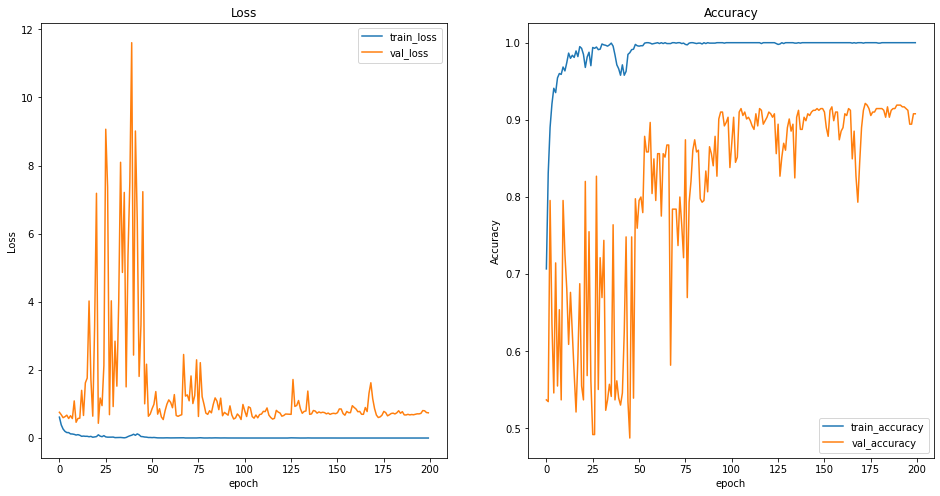

In [16]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [17]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V7_2.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [18]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 1.0% 召回率:  1.0, f1:  1.0
在20%测试集上, accuracy: 0.9213% 召回率: 0.9539748953974896, f1: 0.9287169042769858


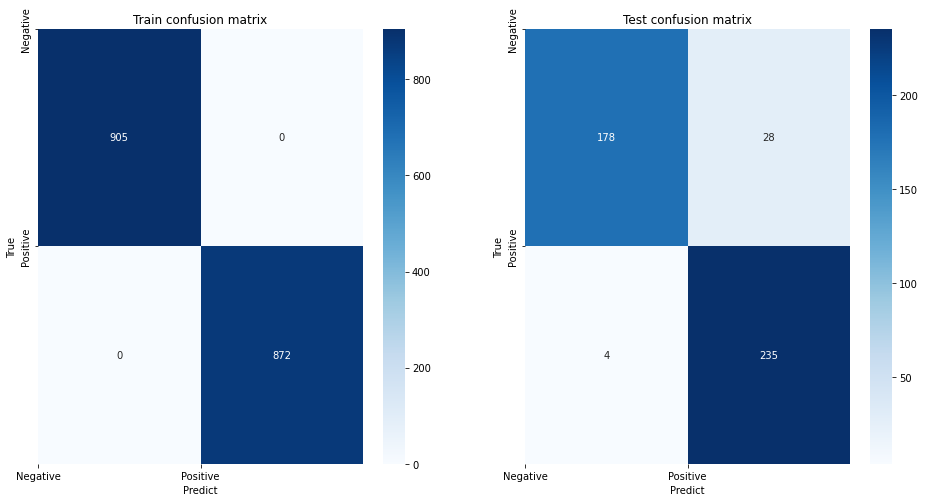

In [66]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()